In [1]:
import numpy as np
import os
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from loading_img import load_images_from_folder
from skimage.transform import resize
from random import sample

In [19]:
classes = []

data_dir = os.path.join(os.getcwd(), 'dataset')
image_paths = defaultdict(list)

#Get every folder names corresponding to a letter
for subdir, dirs, files in os.walk(data_dir):
    if subdir.split('\\')[-1] == 'dataset':
        continue
    folder = subdir.split('\\')[-1]
    classes.append(folder)
    
    #Create image path for every images of every class
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith(".jpg"):
            image_paths[classes[-1]].append(filepath)

img_class_ids = {classe: index for index, classe in enumerate(classes)}

In [20]:
total = 0
for key in image_paths.keys():
    total = total + len(image_paths[key])
    
print(total)

11047


In [21]:
img_class_ids = {classe: index for index, classe in enumerate(classes)}
print(img_class_ids)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [22]:
img_paths_and_classes = []
for classe, paths in image_paths.items():
    for path in paths:
        img_paths_and_classes.append((path, img_class_ids[classe]))

In [23]:
test_ratio = 0.2
train_size = int(len(img_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(img_paths_and_classes)

img_paths_and_classes_train = img_paths_and_classes[:train_size]
img_paths_and_classes_test = img_paths_and_classes[train_size:]

validation_ratio = 0.3
train_size = int(len(img_paths_and_classes_train) * (1 - validation_ratio))

np.random.shuffle(img_paths_and_classes_train)

img_paths_and_classes_training = img_paths_and_classes[:train_size]
img_paths_and_classes_validation = img_paths_and_classes[train_size:]

In [24]:
def prepare_image(image, target_width = 224, target_height = 224):
    
    image_resized_grey = cv2.resize(image,(target_width,target_height))
    image_resized = cv2.cvtColor(image_resized_grey,cv2.COLOR_BGR2RGB)
    
    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image_resized = np.fliplr(image_resized)

    return image_resized.astype(np.float32)

In [25]:
def prepare_batch(img_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(img_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    prepared_images = norm_between_a_b(prepared_images,0,1)
    X_batch = np.stack(prepared_images)
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [26]:
def prepare_all_images(img_paths_and_classes):
    images = [mpimg.imread(path)[:, :, :] for path, labels in img_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    prepared_images = norm_between_a_b(prepared_images,0,1)
    X_all = np.stack(prepared_images)
    Y_all = np.array([labels for path, labels in img_paths_and_classes], dtype=np.int32)
    return X_all, Y_all

In [27]:
def norm_between_a_b(array_img,a,b):
    img_norm = []
    for array in array_img:
        min_array = array.min()
        max_array = array.max()
        array_norm = a-(array-min_array)*(a-b)/(max_array-min_array)
        img_norm.append(array_norm)
    return img_norm

In [28]:
#X_batch, y_batch = prepare_batch(img_paths_and_classes_train,50)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [31]:
inputs = keras.Input(shape=X_train.shape[1:])
print(inputs)

Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)


In [30]:
X_train, y_train = prepare_all_images(img_paths_and_classes_training)
X_val, y_val = prepare_all_images(img_paths_and_classes_validation)
X_test, y_test = prepare_all_images(img_paths_and_classes_test)
inputs = keras.Input(shape=X_train.shape[1:])

NameError: name 'X_train_all' is not defined

In [53]:
model = ResNet50V2(
    include_top=True, weights=None, input_tensor=inputs,
    pooling=True, classes=len(img_class_ids), classifier_activation='softmax')

In [40]:
# image_size = (224, 224)
# batch_size = 50
# len(img_class_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

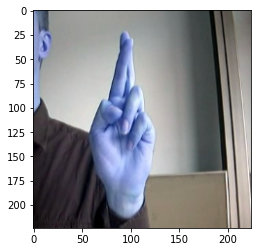

In [41]:
plt.imshow(X_train_all[3])
np.unique(y_train_all)

In [42]:
# train_ds = train_ds.prefetch(buffer_size=50)
# val_ds = val_ds.prefetch(buffer_size=50)

In [54]:
epochs = 30

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

checkpoint_path = "training/test_1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(
    x=X_train,y=y_train, batch_size=50, epochs=epochs, callbacks=cp_callback, validation_data=(X_val,y_val),
)

Epoch 1/30
124/124 [==============================] - ETA: 0s - loss: 2.0323 - accuracy: 0.4666
Epoch 00001: saving model to training\test_1.ckpt
124/124 [==============================] - 44s 357ms/step - loss: 2.0323 - accuracy: 0.4666 - val_loss: 9.1837 - val_accuracy: 0.2682
Epoch 2/30
124/124 [==============================] - ETA: 0s - loss: 1.5589 - accuracy: 0.5727
Epoch 00002: saving model to training\test_1.ckpt
124/124 [==============================] - 43s 344ms/step - loss: 1.5589 - accuracy: 0.5727 - val_loss: 2.9391 - val_accuracy: 0.2921
Epoch 3/30
124/124 [==============================] - ETA: 0s - loss: 1.1572 - accuracy: 0.6564
Epoch 00003: saving model to training\test_1.ckpt
124/124 [==============================] - 43s 345ms/step - loss: 1.1572 - accuracy: 0.6564 - val_loss: 43.3134 - val_accuracy: 0.0278
Epoch 4/30
124/124 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.7335
Epoch 00004: saving model to training\test_1.ckpt
124/124 [====

In [55]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Model, accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(X_test).shape)

70/70 - 4s - loss: 0.2736 - accuracy: 0.9362
Model, accuracy: 93.62%
(2210, 27)


In [11]:
import cv2

In [12]:
from generate_dataset import get_dataset

In [15]:
Train,Test,Val,class_id = get_dataset('dataset')
inputs = keras.Input(Train[0].shape[1:])
#Create Model
model = ResNet50V2(
    include_top=True, weights=None, input_tensor=inputs,
    pooling=True, classes=len(class_id), classifier_activation='softmax')

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.load_weights(r'training/test_1.ckpt')

X_test = Test[0]

plt.imshow(X_test[4])
#cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     color_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Display the resulting frame
#     cv2.imshow('frame',color_img)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()

NameError: name 'plt' is not defined

In [1]:
import cv2
import tensorflow as tf
from generate_dataset import get_dataset

In [2]:
x_train,y_train,x_test,y_test,x_val,y_val,class_id = get_dataset('dataset')

In [7]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
        
callback = myCallback()

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(28, activation=tf.nn.softmax)])

model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=10, callbacks=[callback])

model.evaluate(x_test, y_test)

Epoch 1/10
194/194 [==============================] - 10s 54ms/step - loss: 2.4671 - accuracy: 0.3500 - val_loss: 2.1643 - val_accuracy: 0.4044
Epoch 2/10
194/194 [==============================] - 10s 53ms/step - loss: 1.8239 - accuracy: 0.5019 - val_loss: 1.6615 - val_accuracy: 0.5601
Epoch 3/10
194/194 [==============================] - 10s 53ms/step - loss: 1.2746 - accuracy: 0.6521 - val_loss: 1.4422 - val_accuracy: 0.6049
Epoch 4/10
194/194 [==============================] - 10s 53ms/step - loss: 0.8405 - accuracy: 0.7662 - val_loss: 1.1976 - val_accuracy: 0.6940
Epoch 5/10
194/194 [==============================] - 10s 53ms/step - loss: 0.5247 - accuracy: 0.8571 - val_loss: 1.1677 - val_accuracy: 0.7236
Epoch 6/10
194/194 [==============================] - 10s 53ms/step - loss: 0.3179 - accuracy: 0.9067 - val_loss: 1.3658 - val_accuracy: 0.7236
Epoch 7/10
194/194 [==============================] - 10s 53ms/step - loss: 0.2172 - accuracy: 0.9368 - val_loss: 1.3044 - val_accuracy:

[1.7498290538787842, 0.7316741943359375]

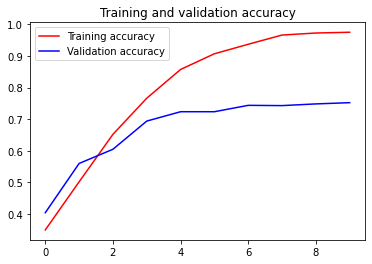

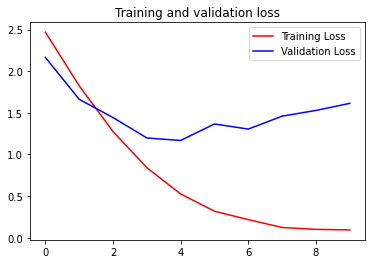

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()